Building classification model to predict if there will be any amount of precipitaion. Precipitation  occured is the minority class(1) no precipitation is the majority class (0). 

Data pulled from GoogleCloud BigQuery public dataset, GHCN Daily from NOAA for JFK Airport, Chatham, Massachusetts, and Albany, New York. 

Business purpose that motivated model choices is a outdoor event planning, tent rental company, where not recommending a tent and it does rain is worse than recommending a tent and it did not rain. 

In [ ]:
import pandas as pd
import numpy as np
from pandas import to_datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_splitr
from sklearn.ensemble import RandomForestClassifier
import datetime as dt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve, f1_score, fbeta_score
import pickle


%matplotlib inline
import matplotlib.cm as cm
import plotly.offline as off
off.init_notebook_mode(connected=False) # allows for offline mode
import plotly.figure_factory as ff
import plotly.graph_objs as go


## JFK Data

In [1502]:
#open pickeled dataframe of NOAA JFK Daily Summaries
with open('jfk_df.pkl', 'rb') as picklefile: 
    df = pickle.load(picklefile)

In [1503]:
#convert date column into three separate columns (year,month,day)
df['date'] = pd.to_datetime(df['date'])
df['YEAR'] = pd.DatetimeIndex(df['date']).year
df['MONTH'] = pd.DatetimeIndex(df['date']).month
df['DAY'] = pd.DatetimeIndex(df['date']).day

In [1171]:
#convert snow and rain data into 1 and 0s for classification
df['snow'] = (df['snow'] > 0 ).astype(int)
df['prcp'] = (df['prcp'] > 0 ).astype(int)
snow_index = list(np.where(df['snow'] == 1)[0])

In [1172]:
#if there was snow, count as a 1 in precipitation column
#Drop snow column, since now accounted for in the precipitation column
df.loc[snow_index, 'prcp'] = 1
df = df.drop(columns=['snow','date'])
#create new feature, if it rained the day before count it as a 1 in the new column(precip_yesterday)
df['prcp_yest'] = df.shift(1)['prcp']
#fill missing values with outlier value (-999) for random classifier model to use
df = df.fillna(-999)

In [1173]:
#create new feature of daily temperature range
df['temp_diff']= df.tmax - df.tmin

In [1175]:
#count precip values to see if there is class imbalance
df.prcp.value_counts()

0    15343
1     7541
Name: prcp, dtype: int64

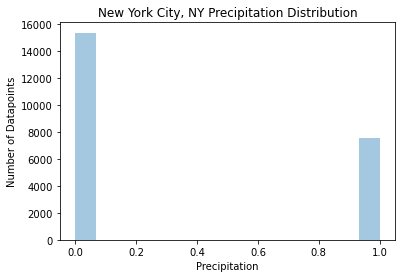

In [1176]:
#count plot precip values to see if there is class imbalance
sns.distplot(df.prcp, kde=False);
plt.title('New York City, NY Precipitation Distribution')
plt.xlabel('Precipitation')
plt.ylabel('Number of Datapoints')
plt.savefig('New York City, NY Precipitation Distribution.png')

In [1177]:
#create X and Y(label) to train/test/split
X= df.loc[:, df.columns != 'prcp']
y = (df['prcp'] > 0 ).astype(int)

In [1178]:
#train,test,split for model use
x1_train, x1_test, y1_train, y1_test = train_test_split(X, y, test_size=.20, random_state=42)

In [1179]:
#random forest classifier model
randomforest = RandomForestClassifier(n_estimators=1000, max_features='sqrt', max_depth=12)
randomforest.fit(x1_train, y1_train)
#randomforest.score(x1_train, y1_train)

0.8339979242912547

In [1180]:
#JFK test data score
#randomforest.score(x1_test, y1_test)

0.736508630107057

In [1422]:
#recall score with .5 threshold
y_pred1 = randomforest.predict(x1_test)
recall_jfk = recall_score(y1_test, y_pred1)
recall_jfk

0.7660972404730617

In [1423]:
#recall score with new .3 threshold, to minimize type 2 error
y_predict_new2 = (randomforest.predict_proba(x1_test)[:, 1] >= .3)
recall_jfk_final = recall_score(y1_test, y_predict_new2)
recall_jfk_final

0.9691195795006571

In [1490]:
#fbeta weighting recall
fbeta_score(y1_test,y_predict_new2,beta=2)

0.7151168428197421

In [1493]:
#f1 score to compare equally weighted precision and recall to the fbeta
#compare to the fbeta to reiterate the choice to weight recall more
f1_score(y1_test,y_predict_new2)

0.5133112928484427

In [1404]:
#plotly to make feature importance graph
import plotly.graph_objects as go
fig = go.Figure(go.Bar(x=randomforest.feature_importances_,
                       y=['Min Temp', 'Max Temp', 'Avg Wind Speed', 'Wind Gust Direction', 'Avg Wind Direction','Year', 'Month', 'Day',  'Rain Yesterday', 'Temp Difference'],\
                       orientation='h'))
fig.layout = dict(
    title = 'JFK Random Forest Feature Importance',
    yaxis = dict(
        title = 'Features',
    ),
    xaxis = dict(
        title = 'Feature Importance',
    ))
fig.update_layout(title_text='JFK Random Forest Feature Importance',yaxis={'categoryorder':'total descending'})
fig.show()                      

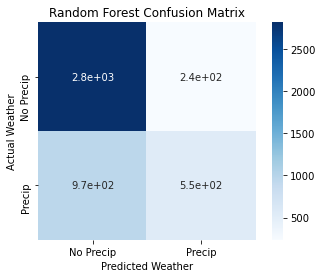

In [1182]:
#confusion matrix with threshold=0.5 for JFK data
#Predict on test data
y_pred1 = randomforest.predict(x1_test)
rf_confusion = confusion_matrix(y1_test, y_pred1)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['No Precip','Precip'],
           yticklabels=['No Precip','Precip'])

plt.xlabel('Predicted Weather')
plt.ylabel('Actual Weather')
plt.title('Random Forest Confusion Matrix');

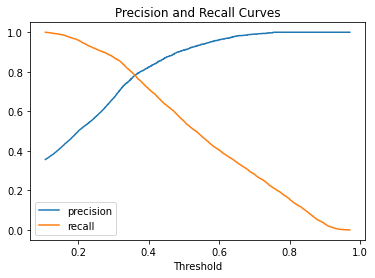

In [1183]:
#precision and recall curve to justify threshold number choice (.3)
y_pred1 = randomforest.predict(x1_train)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y1_train, randomforest.predict_proba(x1_train)[:,1] )

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves');

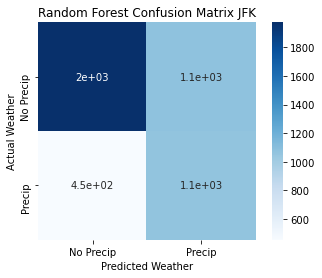

In [1186]:
#confusion matrix of model with new threshold (.3) on test data
y_predict_new2 = (randomforest.predict_proba(x1_test)[:, 1] >= .3)
rf_confusion = confusion_matrix(y1_test, y_predict_new2)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['No Precip','Precip'],
           yticklabels=['No Precip','Precip'])

plt.xlabel('Predicted Weather')
plt.ylabel('Actual Weather')
plt.title('Random Forest Confusion Matrix JFK');

In [1359]:
#predict if it is going to rain for presentation 
#numbers from teperature and wind numbers from weather.com 
randomforest.predict_proba(np.array([6.67,12.77,3.6,90,0,2020,5,6,0,11]).reshape(1, -1))[:,1] >= 0.3

#update: model was correct in prediction 

array([ True])

## Chatham Data

In [1268]:
with open('chatham_df.pkl', 'rb') as picklefile: 
    df2 = pickle.load(picklefile)

In [1269]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16765 entries, 0 to 16764
Data columns (total 8 columns):
date    16765 non-null datetime64[ns]
prcp    16749 non-null float64
tmin    16641 non-null float64
tmax    16645 non-null float64
awnd    0 non-null float64
wdf2    0 non-null float64
wdf5    0 non-null float64
snow    16721 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.0 MB


In [1270]:
df2['date'] = pd.to_datetime(df2['date'])
df2['YEAR'] = pd.DatetimeIndex(df2['date']).year
df2['MONTH'] = pd.DatetimeIndex(df2['date']).month
df2['DAY'] = pd.DatetimeIndex(df2['date']).day

In [1271]:
df2['snow'] = (df2['snow'] > 0 ).astype(int)
df2['prcp'] = (df2['prcp'] > 0 ).astype(int)
snow_index = list(np.where(df2['snow'] == 1)[0])

In [1272]:
df2.loc[snow_index, 'prcp'] = 1
df2 = df2.drop(columns=['snow','date','awnd','wdf2','wdf5'])
df2['prcp_yest'] = df2.shift(1)['prcp']

In [1273]:
df2 = df2.fillna(-999)

In [1304]:
df2['temp_diff']= df2.tmax - df2.tmin

In [1305]:
df2

,prcp,tmin,tmax,YEAR,MONTH,DAY,prcp_yest,temp_diff
0,1,15.0,21.1,1972,8,1,-999.0,6.1
1,0,15.0,21.7,1972,8,2,1.0,6.7
2,0,15.0,20.6,1972,8,3,0.0,5.6
3,1,15.6,22.8,1972,8,4,0.0,7.2
4,0,13.3,21.1,1972,8,5,1.0,7.8
...,...,...,...,...,...,...,...,...
16760,0,2.8,8.9,2020,4,29,1.0,6.1
16761,0,5.6,10.6,2020,4,30,0.0,5.0
16762,1,6.7,9.4,2020,5,1,0.0,2.7
16763,1,7.8,12.2,2020,5,2,1.0,4.4


In [1306]:
df2.prcp.value_counts()

0    10929
1     5836
Name: prcp, dtype: int64

Text(0, 0.5, 'Number of Datapoints')

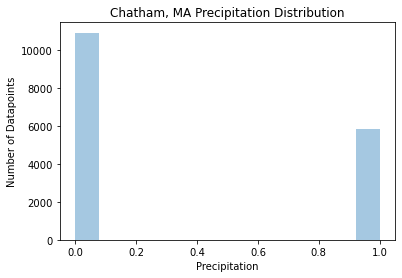

In [1307]:
sns.distplot(df2.prcp, kde=False);
plt.title('Chatham, MA Precipitation Distribution')
plt.xlabel('Precipitation')
plt.ylabel('Number of Datapoints')

In [1308]:
X= df2.loc[:, df2.columns != 'prcp']
y= (df2['prcp'] > 0 ).astype(int)

In [1310]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X, y, test_size=.20, random_state=42)

In [1497]:
randomforest2 = RandomForestClassifier(n_estimators=1000, max_features='sqrt', max_depth = 12)
randomforest2.fit(x2_train, y2_train)
#randomforest2.score(x2_train, y2_train) 

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=12, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [1481]:
y_predict_chat_new = (randomforest2.predict_proba(x2_test)[:, 1] >= .3)
recall_chat_final = recall_score(y2_test, y_predict_chat_new)
recall_chat_final

0.6941580756013745

In [1485]:
fbeta_score(y2_test,y_predict_chat_new,beta=2)

0.619917139788246

In [1500]:
f1_score(y2_test,y_predict_chat_new)

0.5342148760330578

In [1324]:
#list of feature importances for random forest model on Chatham, MA data
list(zip(randomforest2.feature_importances_,X.columns))

[(0.1508320301175562, 'tmin'),
 (0.16214341944189517, 'tmax'),
 (0.16074413128450762, 'YEAR'),
 (0.09039642644647368, 'MONTH'),
 (0.1491872404835517, 'DAY'),
 (0.06789543166445268, 'prcp_yest'),
 (0.21880132056156307, 'temp_diff')]

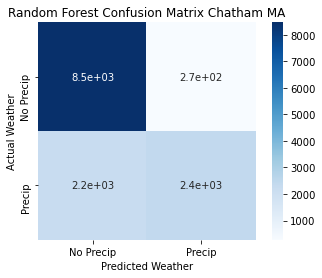

In [1325]:
#confusion matrix of random forest model with threshold .5 on test data (Chatham, MA)
rf2_confusion = confusion_matrix(y2_train, randomforest2.predict(x2_train))
sns.heatmap(rf2_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['No Precip','Precip'],
           yticklabels=['No Precip','Precip'])

plt.xlabel('Predicted Weather')
plt.ylabel('Actual Weather')
plt.title('Random Forest Confusion Matrix Chatham MA');

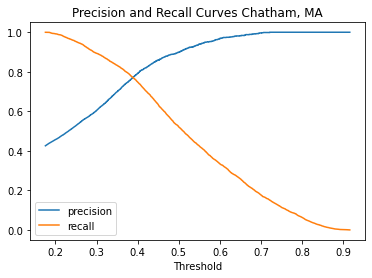

In [1326]:
y_pred2 = randomforest2.predict(x2_train)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y2_train, randomforest2.predict_proba(x2_train)[:,1] )

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves Chatham, MA');

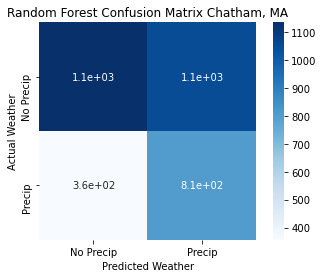

In [1504]:
#confusion matrix of random forest model with .3 threshold on test data
rf_confusion = confusion_matrix(y2_test, y_predict_chat_new)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True,
           xticklabels=['No Precip','Precip'],
           yticklabels=['No Precip','Precip'])

plt.xlabel('Predicted Weather')
plt.ylabel('Actual Weather')
plt.title('Random Forest Confusion Matrix Chatham, MA');

In [ ]:
#check one date of known weather to see if model predicted correctly
#it did not rain on 09/05/2019, model was correct in this prediction
randomforest2.predict_proba(np.array([16.67,25.55,2019,9,5,0]).reshape(1, -1))[:,1] >= 0.3

## Albany, NY Data

In [1450]:
with open('albany_df.pkl', 'rb') as picklefile: 
    df3 = pickle.load(picklefile)

In [1451]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25686 entries, 0 to 25685
Data columns (total 8 columns):
date    25686 non-null datetime64[ns]
prcp    25685 non-null float64
tmin    25686 non-null float64
tmax    25686 non-null float64
awnd    13266 non-null float64
wdf2    9040 non-null float64
wdf5    9020 non-null float64
snow    25553 non-null float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 1.6 MB


In [1452]:
df3['date'] = pd.to_datetime(df3['date'])
df3['YEAR'] = pd.DatetimeIndex(df3['date']).year
df3['MONTH'] = pd.DatetimeIndex(df3['date']).month
df3['DAY'] = pd.DatetimeIndex(df3['date']).day

In [1453]:
df3['snow'] = (df3['snow'] > 0 ).astype(int)
df3['prcp'] = (df3['prcp'] > 0 ).astype(int)
snow_index = list(np.where(df3['snow'] == 1)[0])

In [1454]:
df3.loc[snow_index, 'prcp'] = 1
df3 = df3.drop(columns=['snow','date'])
df3['prcp_yest'] = df3.shift(1)['prcp']

In [1455]:
df3['temp_diff']= df3.tmax - df3.tmin

In [1456]:
df3 = df3.fillna(-999)

In [1457]:
df3.prcp.value_counts()

0    15826
1     9860
Name: prcp, dtype: int64

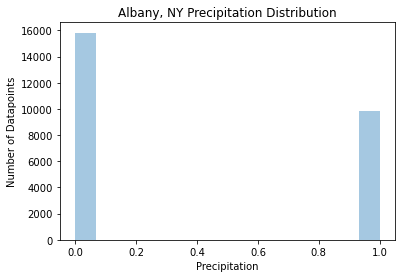

In [1458]:
sns.distplot(df3.prcp, kde=False);
plt.title('Albany, NY Precipitation Distribution')
plt.xlabel('Precipitation')
plt.ylabel('Number of Datapoints')
plt.savefig('New York City, NY Precipitation Distribution.png')

In [1459]:
X= df3.loc[:, df3.columns != 'prcp']
y = (df3['prcp'] > 0 ).astype(int)

In [1436]:
x3_train, x3_test, y3_train, y3_test = train_test_split(X, y, test_size=.20, random_state=42)

In [1437]:
randomforest3 = RandomForestClassifier(n_estimators=1000, max_features='sqrt', max_depth=12)
randomforest3.fit(x3_train, y3_train)
randomforest3.score(x3_train, y3_train)

0.8347771072610473

In [1438]:
randomforest3.score(x3_test, y3_test)

0.7183729077462048

In [1440]:
y_pred3 = randomforest3.predict(x3_test)
recall_alb = recall_score(y3_test, y_pred3)
recall_alb

0.48014440433212996

In [1442]:
y_predict_alb_new = (randomforest3.predict_proba(x3_test)[:, 1] >= .3)
recall_alb_final = recall_score(y3_test, y_predict_alb_new)
recall_alb_final

0.8267148014440433

In [1501]:
f1_score(y3_test,y_predict_alb_new)

0.630357845064884

In [1491]:
fbeta_score(y3_test,y_predict_alb_new,beta=2)

0.7351187746491792

In [1344]:
list(zip(randomforest3.feature_importances_,X.columns))

[(0.1299730984755288, 'tmin'),
 (0.11261723134628562, 'tmax'),
 (0.08626815885971977, 'awnd'),
 (0.03894670387971835, 'wdf2'),
 (0.04036908529800995, 'wdf5'),
 (0.09005769774860406, 'YEAR'),
 (0.060815928222893015, 'MONTH'),
 (0.08180617888441773, 'DAY'),
 (0.03720150690734204, 'prcp_yest'),
 (0.32194441037748067, 'temp_diff')]

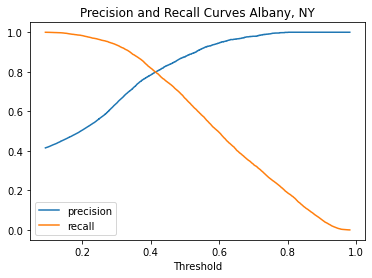

In [1418]:
y_pred3 = randomforest3.predict(x3_train)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y3_train, randomforest3.predict_proba(x3_train)[:,1] )

plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold');
plt.title('Precision and Recall Curves Albany, NY');
plt.savefig('Precision_recall_curve_albany.png')

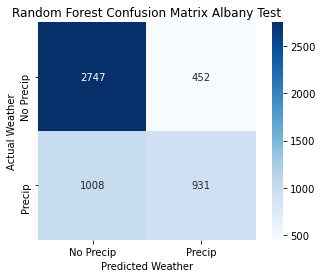

In [1417]:
#confusion matrix with threshold=0.5 for Albany test data
y_predict_test4 = randomforest3.predict(x3_test)
rf_confusion = confusion_matrix(y3_test, y_predict_test4)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt=".0f",
           xticklabels=['No Precip','Precip'],
           yticklabels=['No Precip','Precip'])

plt.xlabel('Predicted Weather')
plt.ylabel('Actual Weather')
plt.title('Random Forest Confusion Matrix Albany Test');
plt.savefig('RndmForest Confusion Matrix Albany Test.png')

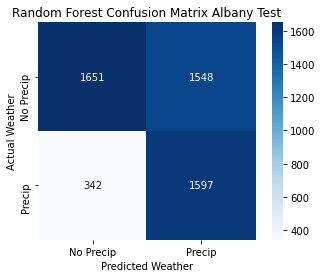

In [1416]:
#confusion matrix with threshold=0.3 for Albany test data
y_predict_test3 = (randomforest3.predict_proba(x3_test)[:, 1] >= .3)
rf_confusion = confusion_matrix(y3_test, y_predict_test3)
sns.heatmap(rf_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt=".0f",
           xticklabels=['No Precip','Precip'],
           yticklabels=['No Precip','Precip'])

plt.xlabel('Predicted Weather')
plt.ylabel('Actual Weather')
plt.title('Random Forest Confusion Matrix Albany Test');
plt.savefig('RndmForest Confusion Matrix Albany Test threshold.png')